<a href="https://colab.research.google.com/github/MariusGuerard/basic_methods/blob/master/simfluence_toy_data_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides an interactive exploration of key concepts from the Simfluence article, accessible [here](https://arxiv.org/pdf/2303.08114.pdf). Utilizing toy data and models, it aims to help understanding of the article's content through Interactive exploration.


# Setup

In [77]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Creating the toy dataset

In [23]:
# Function to create a toy dataset
def create_toy_dataset(
    n_samples: int = 1000,
    random_state: int = 42,
    test_size: float = 0.3,
    ) -> tuple[np.ndarray]:
    """
    Creates a toy dataset for classification.

    Args:
    n_samples: The number of samples to generate.
    random_state: The seed for the random split.
    test_size: The size of the testing set.

    Returns:
    A 4-tuple (X_train, X_test, y_train, y_test), where X_train and X_test are
    the train and test features and y_train, and y_test are the train and test
    labels of the generated dataset.
    """
    X, y = make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=42,
        )
    return train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        )

In [29]:
# Create the splitted toy dataset.
toy_dataset = create_toy_dataset(n_samples=2000)

X_train, X_test, y_train, y_test = toy_dataset

# Creating the curricula and corresponding train and test loss

## Helper Functions

In [43]:
def _compute_loss(
    model: sklearn.base.BaseEstimator,
    dataset: tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    on_train: bool
) -> float:
    """
    Computes the log loss for a given model and dataset.

    This function calculates the log loss on either the training or test set
    based on the `on_train` flag. It uses the model's `predict_proba` method
    to predict probabilities.

    Args:
      model: A machine learning model that implements the `predict_proba` method.
      dataset: A 4-tuple containing training and testing data in the format
               (X_train, X_test, y_train, y_test).
      on_train: A boolean flag to determine if the loss should be calculated
                on the training data (True) or the test data (False).

    Returns:
      A float representing the log loss of the model on the specified dataset.
    """
    X_train, X_test, y_train, y_test = dataset
    if on_train:
      loss = log_loss(y_train, model.predict_proba(X_train))
    else:
      loss = log_loss(y_test, model.predict_proba(X_test))
    return loss



def calculate_loss_changes(
    model: sklearn.base.BaseEstimator,
    dataset: tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    curriculum: list,
    on_train: bool = False
) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the loss for a given model, dataset, and curriculum.

    Executes the following steps:
    1) Initialize the model with a single trianing step on the first element
    of the training curriculum.
    2) For every element of the rest of the curriculum, get the loss of
    the model (pre-training loss), train the model on this element, get the new
    loss of the model (post-training loss). The loss is computed either on the
    training set or the testing set depending on the on_train argument.
    3) Reshape the loss to train a model to predict the post-training loss.

    Args:
      model: The machine learning model to train.
      dataset: The dataset as a 4-tuple (X_train, X_test, y_train, y_test).
      curriculum: The order of training examples.

    Returns:
      X_loss: A combination of pre-training loss and feature used for training.
      y_loss: The post-training loss.
    """
    X_loss = []
    y_loss = []

    for i, ci in enumerate(curriculum):
      if i == 0:
        model.partial_fit(
            X_train[[ci]],
            y_train[[ci]],
            classes=np.unique(y_train),
            )
      else:
        loss_before = _compute_loss(model, dataset, on_train)
        # Train on the example
        model.partial_fit(
            X_train[[ci]],
            y_train[[ci]],
            classes=np.unique(y_train),
            )
        loss_after = _compute_loss(model, dataset, on_train)
        # Combine pre-training loss with the training example features.
        X_loss.append([loss_before] + list(X_train[ci]))
        y_loss.append(loss_after)
    return np.array(X_loss), np.array(y_loss)

## Simple case

In [ ]:
# Creating 3 curricula (minimum 2 to have enough data points to train a function)
curriculum_1 = np.random.choice(len(X_train), size=len(X_train), replace=False)
curriculum_2 = np.random.choice(len(X_train), size=len(X_train), replace=False)
curriculum_3 = np.random.choice(len(X_train), size=len(X_train), replace=False)

train_curriculum = np.concatenate([curriculum_1, curriculum_2, curriculum_3])

In [44]:
# Computing test loss. you can generate the train loss using on_train=True.
mlp_model = MLPClassifier(hidden_layer_sizes=(15,), random_state=42)
X_test_loss, y_test_loss = calculate_loss_changes(
    mlp_model, toy_dataset, train_curriculum
)

In [45]:
X_test_loss.shape, y_test_loss.shape

((4199, 3), (4199,))

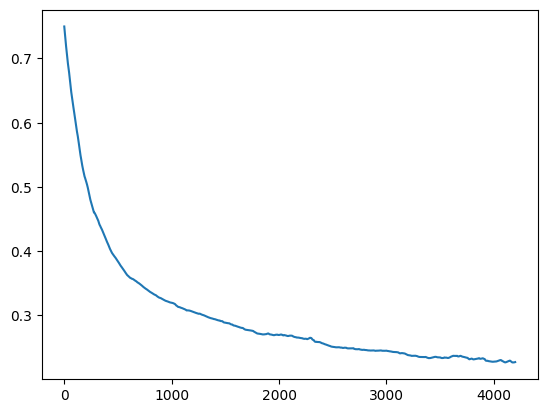

In [46]:
plt.plot(X_test_loss[:, 0])

## More complex case

In this case we design a custom curriculum where the model just see one class before seeing the other class. That should create a loss function that is plateauing until we give the model the other class.

In [90]:
# Step 1: Create the new curricula
# We want the first 500 samples to be of the same class, let's choose class 0 for simplicity
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

# Make sure we have at least 200 samples of class 0
if len(class_0_indices) < 200:
    raise ValueError("Not enough samples of class 0 to create the curricula.")

# Select the first 200 samples of class 0
curriculum_1 = np.random.choice(class_0_indices, size=600, replace=False)

# The rest of the curricula will contain a mix of classes
curriculum_2 = np.random.choice(len(X_train), size=len(X_train), replace=False)
curriculum_3 = np.random.choice(len(X_train), size=len(X_train), replace=False)

train_curriculum_skewed = np.concatenate([curriculum_1, curriculum_2, curriculum_3])

# Step 2: Train the MLPClassifier on the new curricula and get the actual loss changes
mlp_model_new_curricula = MLPClassifier(hidden_layer_sizes=(15,), random_state=42)
X_test_skewed_loss, y_test_skewed_loss = calculate_loss_changes(
    mlp_model_new_curricula, toy_dataset, train_curriculum_skewed
)

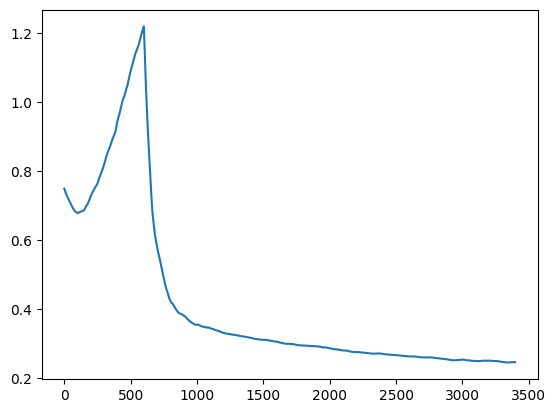

In [91]:
plt.plot(y_test_skewed_loss)

# Training the loss predictor

Training both a model on the simple curriculum (named simple_loss_model) and a model on the complex curriculum (named complex_loss_model).

In [97]:
simple_loss_model = LinearRegression().fit(X_test_loss, y_test_loss)
complex_loss_model = LinearRegression().fit(X_test_skewed_loss, y_test_skewed_loss)

# Estimating a loss curve from an initial loss

## Helper Function

In [58]:
# Function to simulate the entire loss trajectory
def simulate_loss_trajectory(
    model: sklearn.base.BaseEstimator,
    initial_loss: float,
    X_train: np.ndarray,
    curriculum: list[int]
) -> list[float]:
    """
    Simulates the entire loss trajectory for a given curriculum using the trained model.

    Args:
    model: Trained linear regression model for loss prediction.
    initial_loss: Initial loss from which to start the simulation.
    X_train: The training feature set.
    curriculum: The order of training examples.

    Returns:
    predicted_loss: List of predicted losses for the entire curriculum.
    """
    predicted_loss = [initial_loss]
    current_loss = initial_loss

    for idx in curriculum:
        # Prepare the input for the model: [current_loss, X_train[idx]]
        Xt = np.array([current_loss] + list(X_train[idx])).reshape(1, -1)

        # Predict the next loss and update current_loss
        post_training_loss_est = model.predict(Xt)[0]
        predicted_loss.append(post_training_loss_est)
        current_loss = post_training_loss_est

    return predicted_loss

In [79]:
def plot_loss_comparison(
    actual_losses: list[float],
    simulated_losses: list[float]
) -> None:
    """
    Plots a comparison of actual versus simulated loss over curriculum steps.

    This function creates a line plot showing the trajectory of actual and
    simulated loss over curriculum steps. Actual loss is in blue, simulated
    in orange.

    Args:
      actual_losses: List of actual loss values over curriculum steps.
      simulated_losses: List of simulated loss values over steps.

    """
    plt.figure(figsize=(10, 6))
    plt.plot(actual_losses, label='Actual Loss', color='blue')
    plt.plot(simulated_losses, label='Simulated Loss', color='orange')
    plt.xlabel('Steps in Curricula')
    plt.ylabel('Loss')
    plt.title('Actual vs Simulated Loss')
    plt.legend()
    plt.show()


## Simple loss model on simple curriculum.



In [98]:
# Simulating the loss trajectory
initial_loss = X_test_loss[0, 0]
predicted_loss_trajectory_0 = simulate_loss_trajectory(
    simple_loss_model, initial_loss, X_train, train_curriculum
)

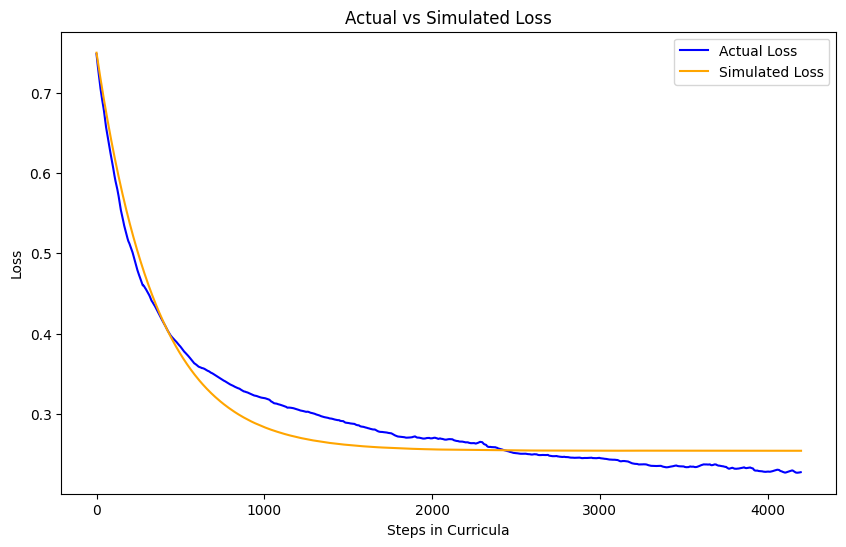

In [99]:
plot_loss_comparison(
    actual_losses=y_test_loss,
    simulated_losses=predicted_loss_trajectory_0,
)

## Complex loss model on simple curriculum.


In [100]:
# Simulating the loss trajectory
initial_loss = X_test_loss[0, 0]
predicted_loss_trajectory_1 = simulate_loss_trajectory(
    complex_loss_model, initial_loss, X_train, train_curriculum
)

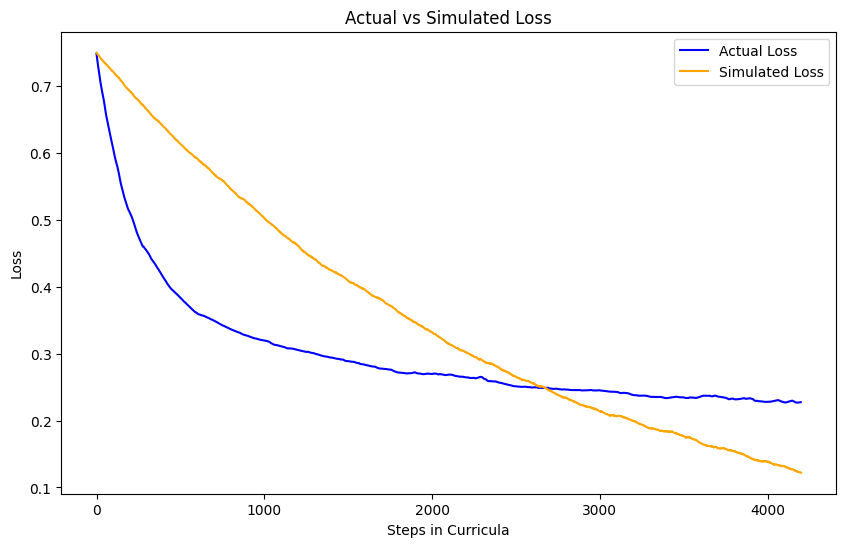

In [101]:
plot_loss_comparison(
    actual_losses=y_test_loss,
    simulated_losses=predicted_loss_trajectory_1,
)

## Simple loss model on complex curriculum.


In [105]:
# Simulating the loss trajectory
initial_loss_new_curricula = X_test_skewed_loss[0, 0]
predicted_loss_trajectory_2 = simulate_loss_trajectory(
    simple_loss_model, initial_loss_new_curricula, X_train, train_curriculum_skewed
)

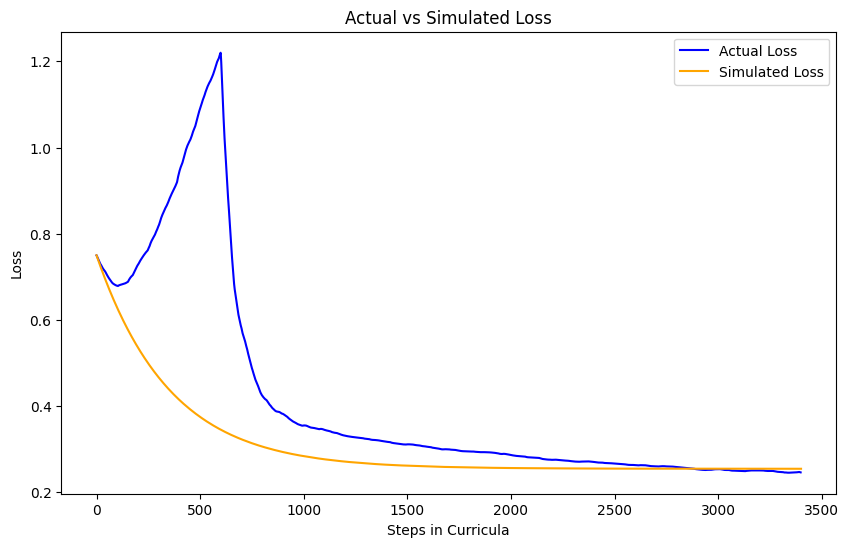

In [106]:
plot_loss_comparison(
    actual_losses=y_test_skewed_loss,
    simulated_losses=predicted_loss_trajectory_2,
)

## Complex loss model on complex curriculum.


In [107]:
# Simulating the loss trajectory
initial_loss_new_curricula = X_test_skewed_loss[0, 0]
predicted_loss_trajectory_3 = simulate_loss_trajectory(
    complex_loss_model, initial_loss_new_curricula, X_train, train_curriculum_skewed
)

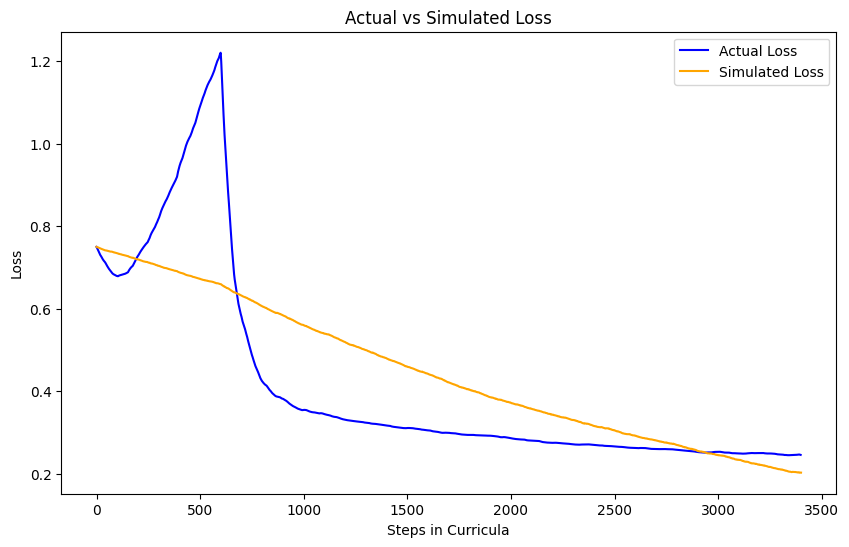

In [108]:
plot_loss_comparison(
    actual_losses=y_test_skewed_loss,
    simulated_losses=predicted_loss_trajectory_3,
)

# Next steps

We see that the linear model trained on a single step is not very good to predict none simple loss function and out-of-domain loss functions. There are multiple things we could try next.

1. Check what the model is actually learning: does the loss_model actually care about the train features, or is it only autoregressive? We can test that by training the loss-model on the pre-training loss only, not the training features, and see if we notice a difference in the performance of the loss-model.

2. Try to see if we can learn more complex loss functions. Multiple things could help:
- More complex models than linear regression.
- Create an embedding for the accumulation of all the curricula that have been used for training **so far**. or
- Train a model on a padded sequence of curricula ([co, nan, ..., nan], [c0, c1, nan, ..., nan]) instead of single element.

As noted in the article, "The only requirements are that the simulator should run much faster than actual training, and should be learnable from a modest number of previously observed runs."